In [22]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install torchmetrics
import torchmetrics
from tqdm import tqdm
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

Defaulting to user installation because normal site-packages is not writeable


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)

In [4]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import os


# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

motion_transform_train = transforms.Compose([normalize])

content_transform_train = transforms.Compose([
                                    transforms.RandomResizedCrop(size=(160,240)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])



class CompDataset(Dataset):
    def __init__(self, data_dir, num_frames=22, motion_transform=motion_transform_train, content_transform=content_transform_train):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.content_transform = content_transform
        self.num_frames = num_frames
        self.video_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            self.video_list.append(self.data_dir +"/"+vid_dir)
            self.count +=1

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        
        video_dir = self.video_list[idx]
        frame_list = []
        frame_list_aug = []
        
        for i in range(self.num_frames):
            image = read_image(video_dir + "/" + "image_"+str(i)+".png")
            image = image/255.0
            image_aug= None
            
            if self.motion_transform:
                image = self.motion_transform(image)
            
            if self.content_transform:
                image_aug = self.content_transform(image)
            
            frame_list.append(image)
            frame_list_aug.append(image_aug)

        label = -1
        
        
        if os.path.isfile(video_dir+"/mask.npy"):
            try:
                label = np.load(video_dir+"/mask.npy")
            except:
                return None, None, None
        

        return frame_list, frame_list_aug, label

In [5]:
labeled_data = CompDataset("/dataset/dataset/train")
val_data = CompDataset("/dataset/dataset/val")

downstream_dataloader = DataLoader(labeled_data, batch_size=3, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)

In [6]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = (out_channels + in_channels)//2
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
 
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
 class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 49, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        factor = 2 if bilinear else 1
        
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024 // factor))
        
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [8]:
def train_fine_tune(downstream_model, epochs, dataloader, criterion, optimizer, DOWNSTREAM_PATH):
    downstream_model.train()

    train_losses = []

    best_loss = float("inf")
    best_model = {}

    for _ in range(epochs):
        total_train_loss = 0.0
        total_train_correct = 0.0

        pbar = tqdm(dataloader, leave=False)

        for j, batch in enumerate(pbar):
          
            if j == 333:
                break
                
            frame_list, frame_list_aug, mask_list = batch[0], batch[1], batch[2] # TODO
            total_train_loss = 0.0
            

            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                img3 = frame_list_aug[i].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)

                logits = downstream_model(img1)
                loss = criterion(logits, mask_list[:,i])
                total_train_loss += loss.item()


                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

            if total_train_loss/(len(frame_list)-1) < best_loss:
                best_loss = total_train_loss/(len(frame_list)-1)
                best_model = downstream_model.state_dict()

            if j%25 == 0:
                torch.save(best_model,DOWNSTREAM_PATH)
                pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved downstream model with loss': best_loss})
          
        pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved model at j': j})
        torch.save(best_model, DOWNSTREAM_PATH)

In [9]:
downstream_model = UNet().to(device)
downstream_optimizer = optim.SGD(downstream_model.parameters(),
                          lr=1e-5, weight_decay=1e-8, momentum=0.999, foreach=True)

def dice_coeff(masks_pred, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    sum_dim = (-1, -2) if masks_pred.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (masks_pred * target).sum(dim=sum_dim)
    sets_sum = masks_pred.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(masks_pred, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(masks_pred.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(masks_pred, target, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(masks_pred, target, reduce_batch_first=True)

cross = nn.CrossEntropyLoss()

def downstream_criterion(masks_pred, true_masks):
    loss = cross(masks_pred, true_masks)
    loss += dice_loss(F.softmax(masks_pred, dim=1).float(), F.one_hot(true_masks, 49).permute(0, 3, 1, 2).float())
    return loss

In [10]:
DOWNSTREAM_PATH = "best_downstream_model.pth"
downstream_model.load_state_dict(torch.load(DOWNSTREAM_PATH))

<All keys matched successfully>

In [13]:
train_fine_tune(downstream_model, 5, downstream_dataloader, downstream_criterion, downstream_optimizer, DOWNSTREAM_PATH)

  0%|          | 0/334 [00:00<?, ?it/s]/ext3/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: 

In [20]:
def test(downstream_model, epochs, dataloader, criterion):
    train_losses = []

    best_loss = float("inf")
    best_model = downstream_model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0

        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
          
            frame_list, frame_list_aug, mask_list = batch[0], batch[1], batch[2] # TODO
            total_train_loss = 0.0
            avg_jacc = 0.0

            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                img3 = frame_list_aug[i].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)

                mask_pred = downstream_model(img1)
                if i == 20:
                    print(jaccard(mask_pred, mask_list[:,i]))
                    plt.imshow(mask_list[0][i].cpu())
                    plt.show()
                    plt.imshow(mask_pred.argmax(dim=1)[0].float().cpu())
                    plt.show()
                loss = criterion(mask_pred, mask_list[:,i])
                total_train_loss += loss.item()
                avg_jacc += jaccard(mask_pred, mask_list[:,i])
                pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'avg_jaccard': avg_jacc.item() / (j+1)}) 

            avg_jacc /= len(dataloader)
            print("Average Jaccard: ", avg_jacc)

  0%|          | 0/1000 [00:00<?, ?it/s]/ext3/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/1000 [00:02<?, ?it/s, Per frame Loss=0.0955, avg_jaccard=1.58]   

tensor(0.0648, device='cuda:0')


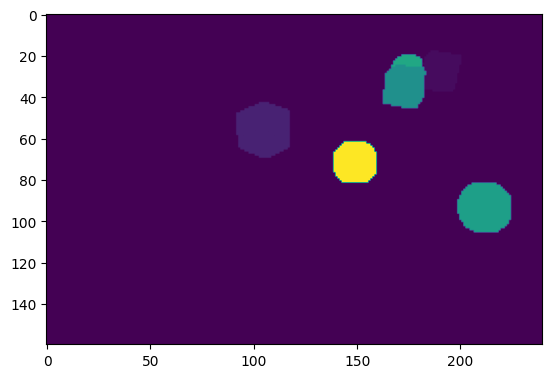

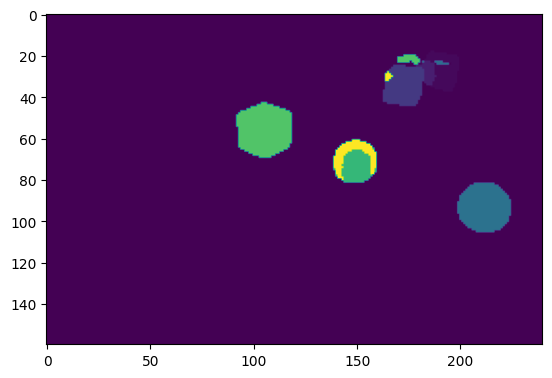

  0%|          | 1/1000 [00:03<52:05,  3.13s/it, Per frame Loss=0.00233, avg_jaccard=0.0243]

Average Jaccard:  tensor(0.0016, device='cuda:0')


  0%|          | 1/1000 [00:05<52:05,  3.13s/it, Per frame Loss=0.0956, avg_jaccard=0.534]  

tensor(0.0543, device='cuda:0')


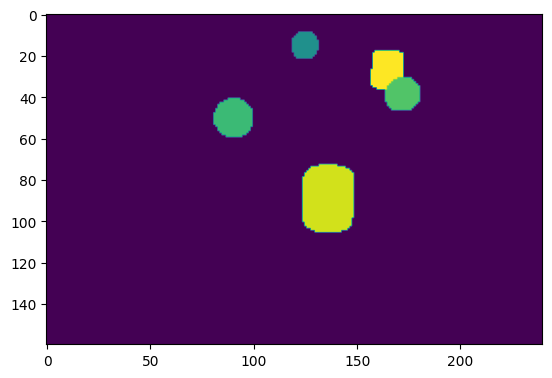

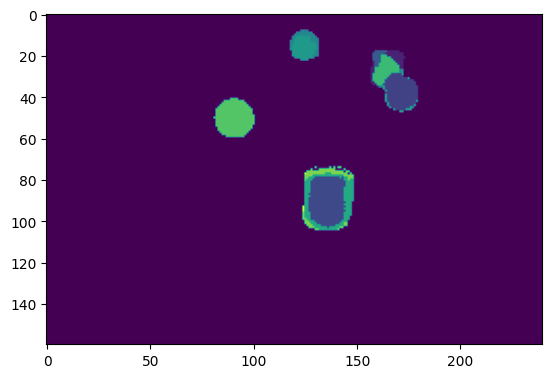

  0%|          | 2/1000 [00:06<51:15,  3.08s/it, Per frame Loss=0.101, avg_jaccard=0.561] 

Average Jaccard:  tensor(0.0011, device='cuda:0')


  0%|          | 2/1000 [00:08<51:15,  3.08s/it, Per frame Loss=0.0917, avg_jaccard=0.32]   

tensor(0.0522, device='cuda:0')


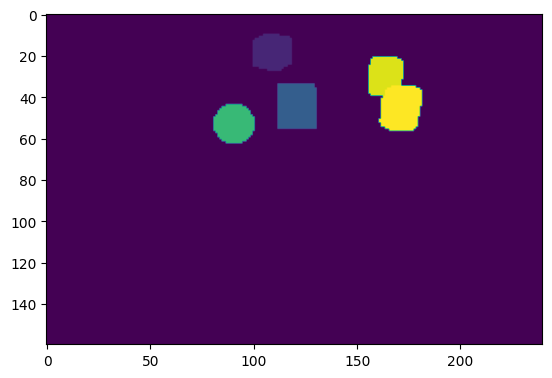

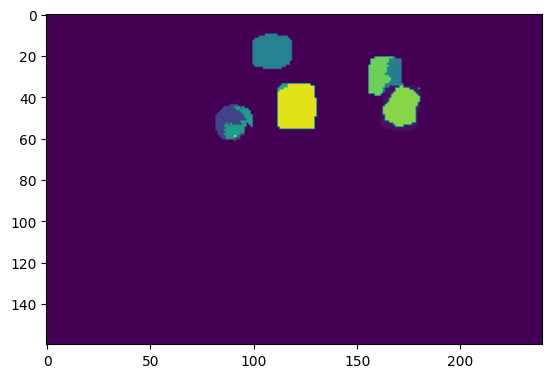

  0%|          | 3/1000 [00:09<51:15,  3.08s/it, Per frame Loss=0.0971, avg_jaccard=0.337]

Average Jaccard:  tensor(0.0010, device='cuda:0')


  0%|          | 3/1000 [00:11<51:15,  3.08s/it, Per frame Loss=0.108, avg_jaccard=0.425]   

tensor(0.0863, device='cuda:0')


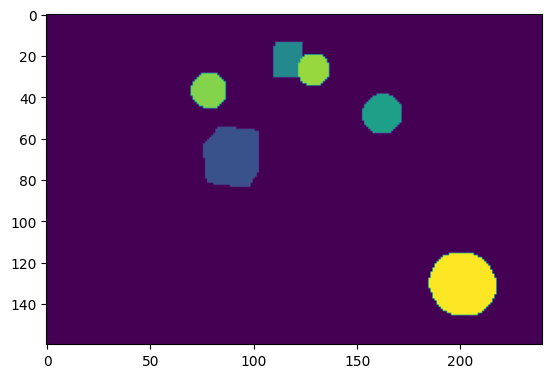

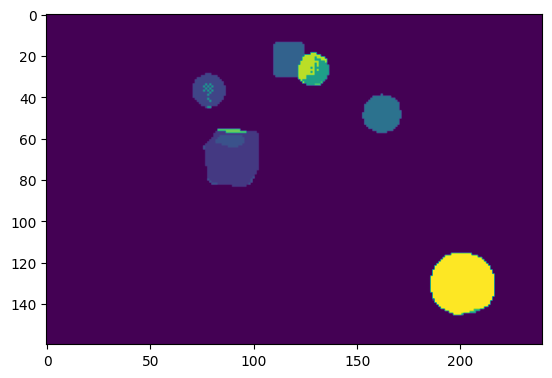

  0%|          | 4/1000 [00:12<50:35,  3.05s/it, Per frame Loss=0.114, avg_jaccard=0.446]

Average Jaccard:  tensor(0.0018, device='cuda:0')


  0%|          | 4/1000 [00:14<50:35,  3.05s/it, Per frame Loss=0.137, avg_jaccard=0.203]    

tensor(0.0495, device='cuda:0')


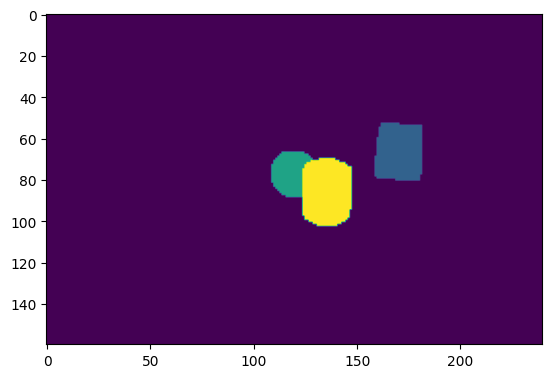

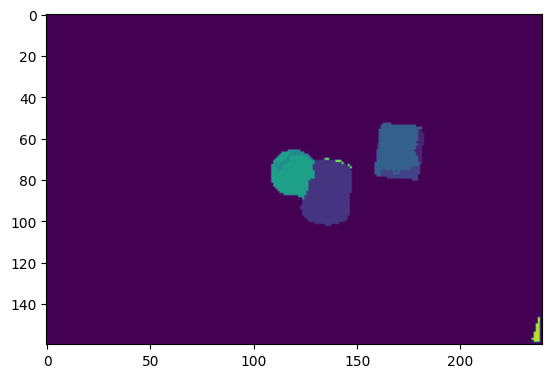

  0%|          | 5/1000 [00:15<50:30,  3.05s/it, Per frame Loss=0.141, avg_jaccard=0.213]

Average Jaccard:  tensor(0.0011, device='cuda:0')


  0%|          | 5/1000 [00:17<50:30,  3.05s/it, Per frame Loss=0.121, avg_jaccard=0.296]   

tensor(0.0873, device='cuda:0')


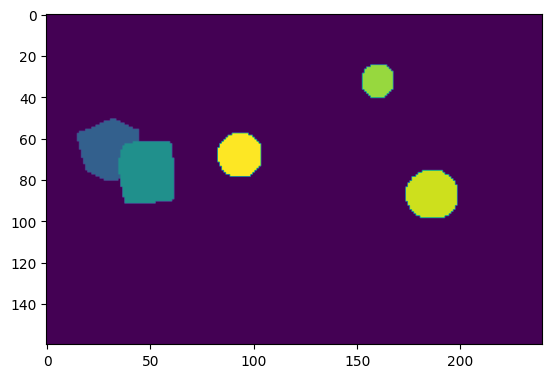

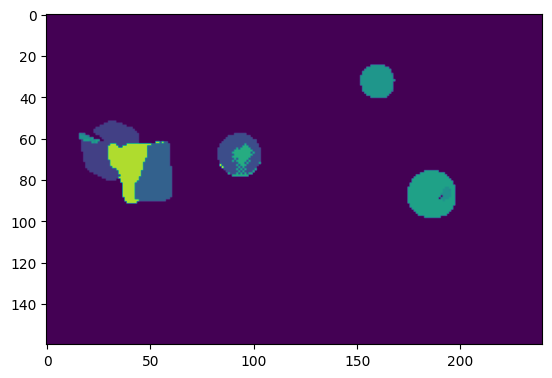

  1%|          | 6/1000 [00:18<50:02,  3.02s/it, Per frame Loss=0.126, avg_jaccard=0.311]

Average Jaccard:  tensor(0.0019, device='cuda:0')


  1%|          | 6/1000 [00:20<50:02,  3.02s/it, Per frame Loss=0.159, avg_jaccard=0.143]   

tensor(0.0606, device='cuda:0')


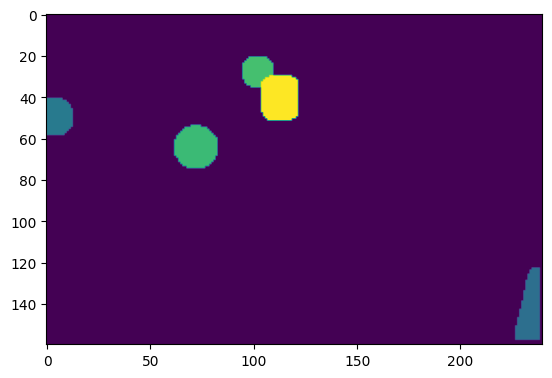

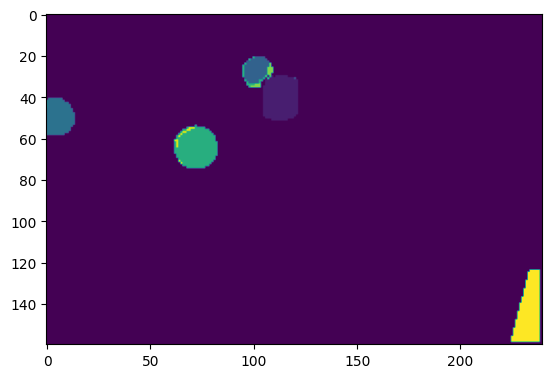

  1%|          | 7/1000 [00:21<50:26,  3.05s/it, Per frame Loss=0.163, avg_jaccard=0.152]

Average Jaccard:  tensor(0.0011, device='cuda:0')


  1%|          | 7/1000 [00:23<50:26,  3.05s/it, Per frame Loss=0.0948, avg_jaccard=0.146]   

tensor(0.0572, device='cuda:0')


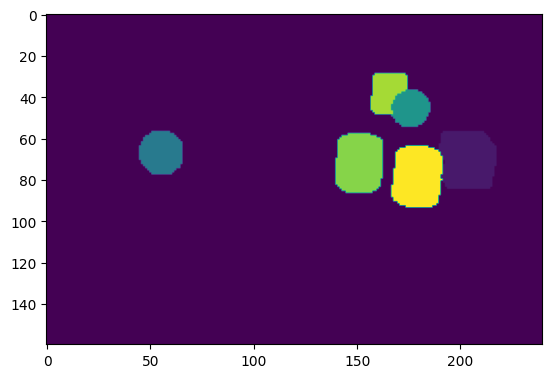

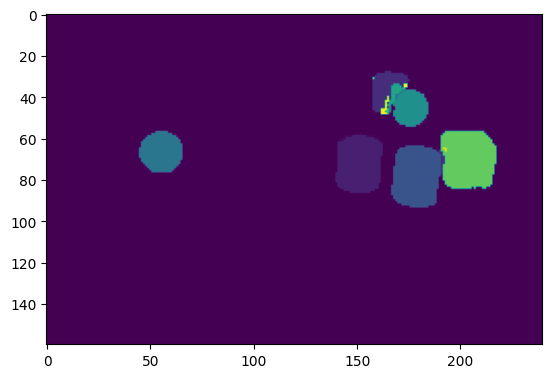

  1%|          | 8/1000 [00:24<50:06,  3.03s/it, Per frame Loss=0.00451, avg_jaccard=0.00636]

Average Jaccard:  tensor(0.0012, device='cuda:0')


  1%|          | 8/1000 [00:26<50:06,  3.03s/it, Per frame Loss=0.104, avg_jaccard=0.161]    

tensor(0.0740, device='cuda:0')


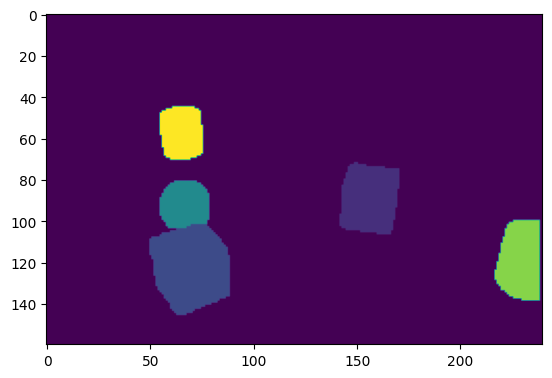

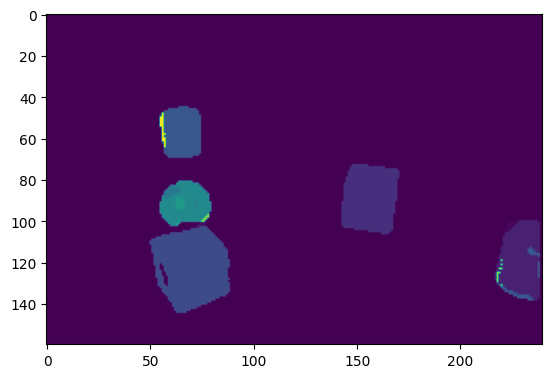

  1%|          | 9/1000 [00:27<49:15,  2.98s/it, Per frame Loss=0.113, avg_jaccard=0.169]

Average Jaccard:  tensor(0.0015, device='cuda:0')


  1%|          | 9/1000 [00:29<49:15,  2.98s/it, Per frame Loss=0.0882, avg_jaccard=0.148]   

tensor(0.0568, device='cuda:0')


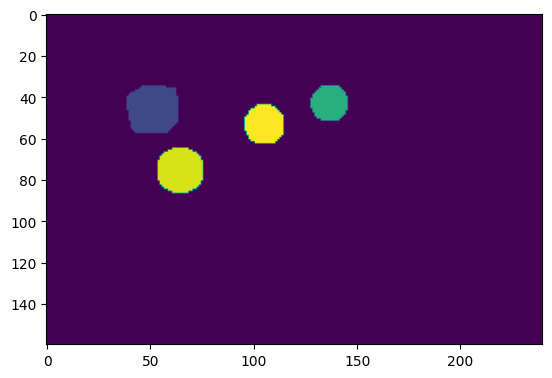

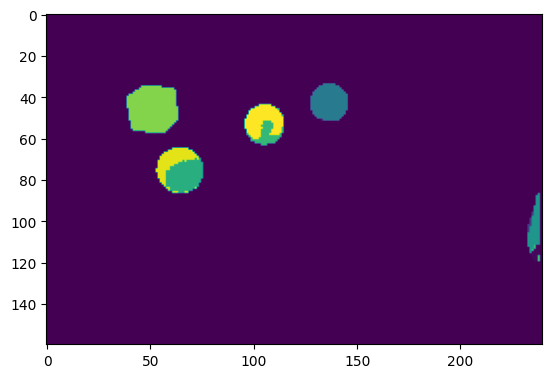

  1%|          | 10/1000 [00:30<49:09,  2.98s/it, Per frame Loss=0.0922, avg_jaccard=0.153]

Average Jaccard:  tensor(0.0015, device='cuda:0')


  1%|          | 10/1000 [00:32<49:09,  2.98s/it, Per frame Loss=0.112, avg_jaccard=0.0649]  

tensor(0.0498, device='cuda:0')


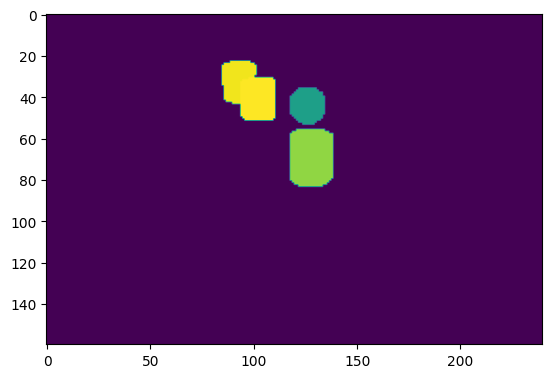

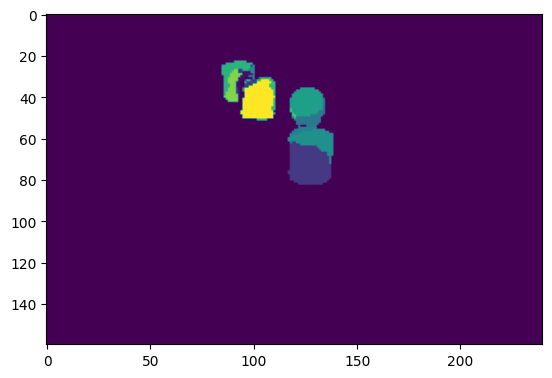

  1%|          | 11/1000 [00:33<49:33,  3.01s/it, Per frame Loss=0.118, avg_jaccard=0.0694]

Average Jaccard:  tensor(0.0008, device='cuda:0')


  1%|          | 11/1000 [00:35<49:33,  3.01s/it, Per frame Loss=0.0561, avg_jaccard=0.141]   

tensor(0.0876, device='cuda:0')


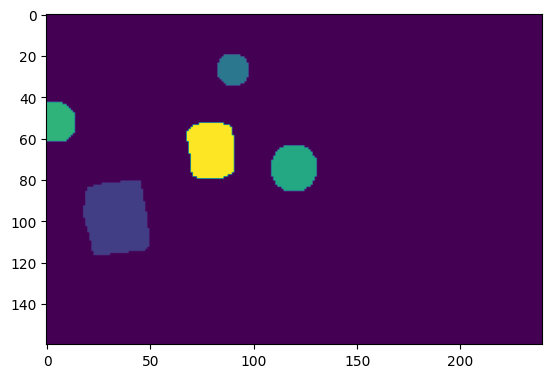

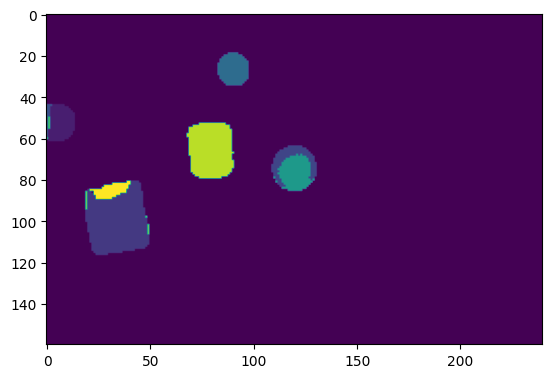

  1%|          | 12/1000 [00:36<49:36,  3.01s/it, Per frame Loss=0.0608, avg_jaccard=0.149]

Average Jaccard:  tensor(0.0018, device='cuda:0')


  1%|          | 12/1000 [00:38<49:36,  3.01s/it, Per frame Loss=0.0715, avg_jaccard=0.0857]  

tensor(0.0515, device='cuda:0')


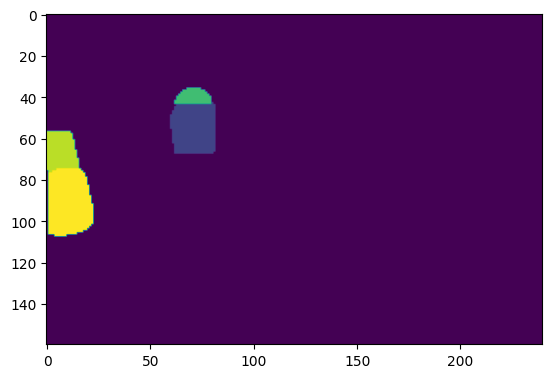

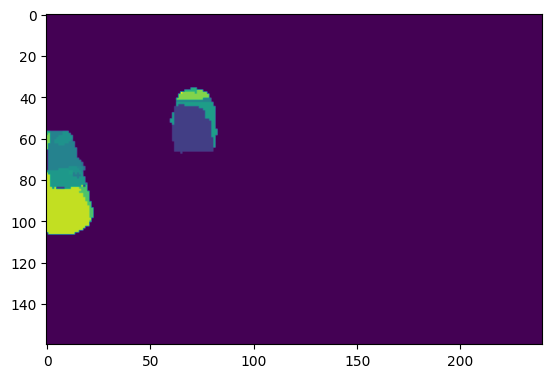

  1%|▏         | 13/1000 [00:39<49:57,  3.04s/it, Per frame Loss=0.0761, avg_jaccard=0.0896]

Average Jaccard:  tensor(0.0012, device='cuda:0')


KeyboardInterrupt: 

In [23]:
test(downstream_model, 1, val_dataloader, downstream_criterion)